# 0.주제
시각장애인들을 위한 점자 번역기

# 1.주제 선정이유
현재 전세계가 하나가 됨에 따라 서로의 문화, 언어가 다른 사람들의 소통이 많아지고 있다. 이에 따라 다양한 번역기가 존재한다. 하지만, 사회적 약자인 시각장애인과 문화를 이어주는 점자번역기의 기능이 다른 번역기들에 비해 떨어지고 보완할 점이 많다고 생각한다. 따라서 점자를 한글로, 나아가 소리로 번역해 줌으로써 시각장애인들이 조금이나마 문화를 누리는 데 도움을 주고자 이 프로젝트를 선정하였다.

# 2.보완해야 할 점
기존의 점자 번역기 같은 경우 약어 때문에 한 점자에 대한 해석이 두가지가 나오는 경우가 있다. 따라서 약어에 대한 번역이 불가능하다. 또한, 점자들을 번역할때 점자들을 일일이 입력하는 형식이기 때문에 시각장애인들의 경우 이러한 번역기를 사용하기 힘들다. 따라서 점자의 규칙성을 이용하여 초성, 중성, 종성, 약어를 구분할 수 있도록 할 것이다. 또한, 이미지 인식을 통해 쉽게 점자들을 인식할 수 있도록 할 것이다.

# 3.데이터 획득 방법
경기도 시각 장애인 도서관을 통해 점자 서적을 빌린다. 이후 점자 책 안의 내용을 명암이 생기도록 여러 각도에서 사진을 찍어 데이터를 획득한다.

# 4.데이터 가공 방법
점자판에 있는 점자 블록을 명암이 생기도록 각도를 조절하여 사진을 찍는다. 이후 이러한 명암을 인식하여 2D형식의 점자판으로 만든다. 그리고 앞서 기본 점자표를 통해 지도학습 시킨 인공지능이 해당 단어를 올바르게 인식하도록 계속해서 시도한다. 그 과정에서 앞뒤 문맥을 파악함으로써 약어에 따른 문제점을 해결한다. 이후 인식된 결과로써 나온 단어를 소리로 번역해준다.


# 5.코드설명

1. 이미지 처리를 위한 cv2
2. 이미지 안에 있는 좌표를 기록하기 위한 numpy
3. 처리한 이미지를 보여주기 위한 plt

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#### 점자 이미지 불러오기

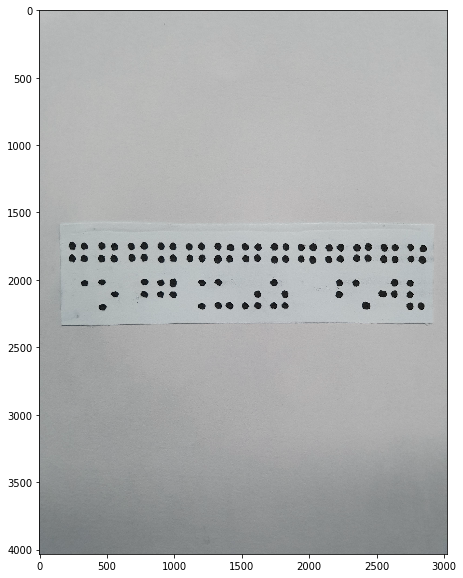

In [2]:
img1_ori = cv2.imread('jeomja1.jpg')
height, width, channel = img1_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img1_ori,cmap = 'gray')

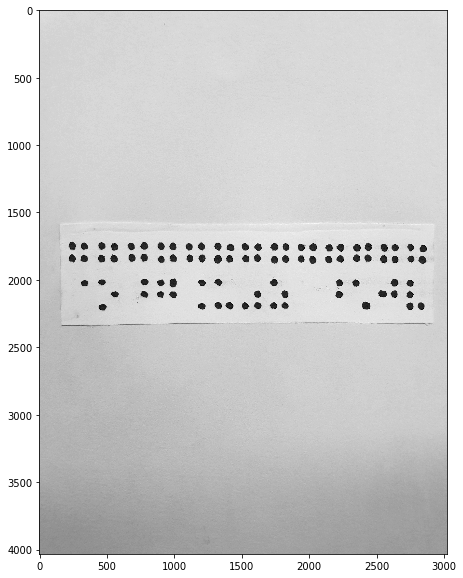

In [3]:
img1_gray = cv2.cvtColor(img1_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(img1_gray,cmap='gray')

#### 이미지 필터링을 위한 Blur처리

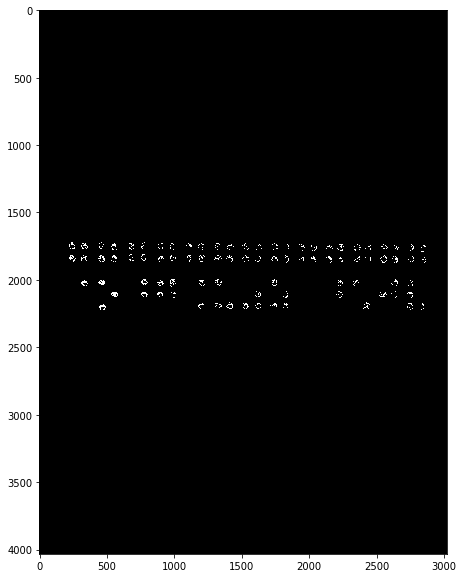

In [4]:
img1_blurred = cv2.GaussianBlur(img1_gray,ksize=(5,5),sigmaX=0)

ret, img1_binary = cv2.threshold(img1_blurred, 30, 255, cv2.THRESH_BINARY_INV)
plt.figure(figsize=(12,10))
plt.imshow(img1_binary,cmap='gray')


#### 점자의 점들의 Contour찾기

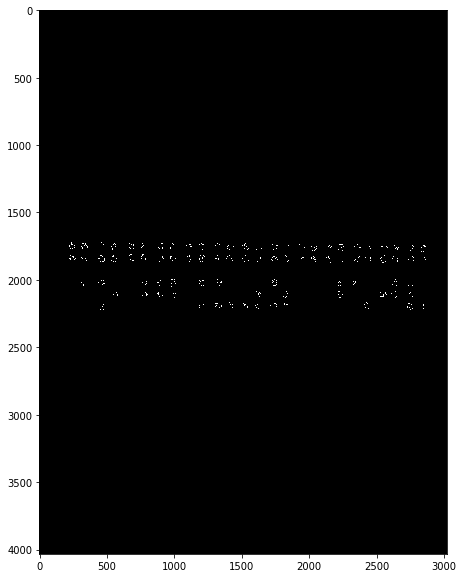

In [5]:
img1_contours, _ = cv2.findContours(
    img1_binary,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

img1_temp_result = np.zeros((height, width, channel), dtype = np.uint8)

cv2.drawContours(img1_temp_result, contours = img1_contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12,10))
plt.imshow(img1_temp_result)


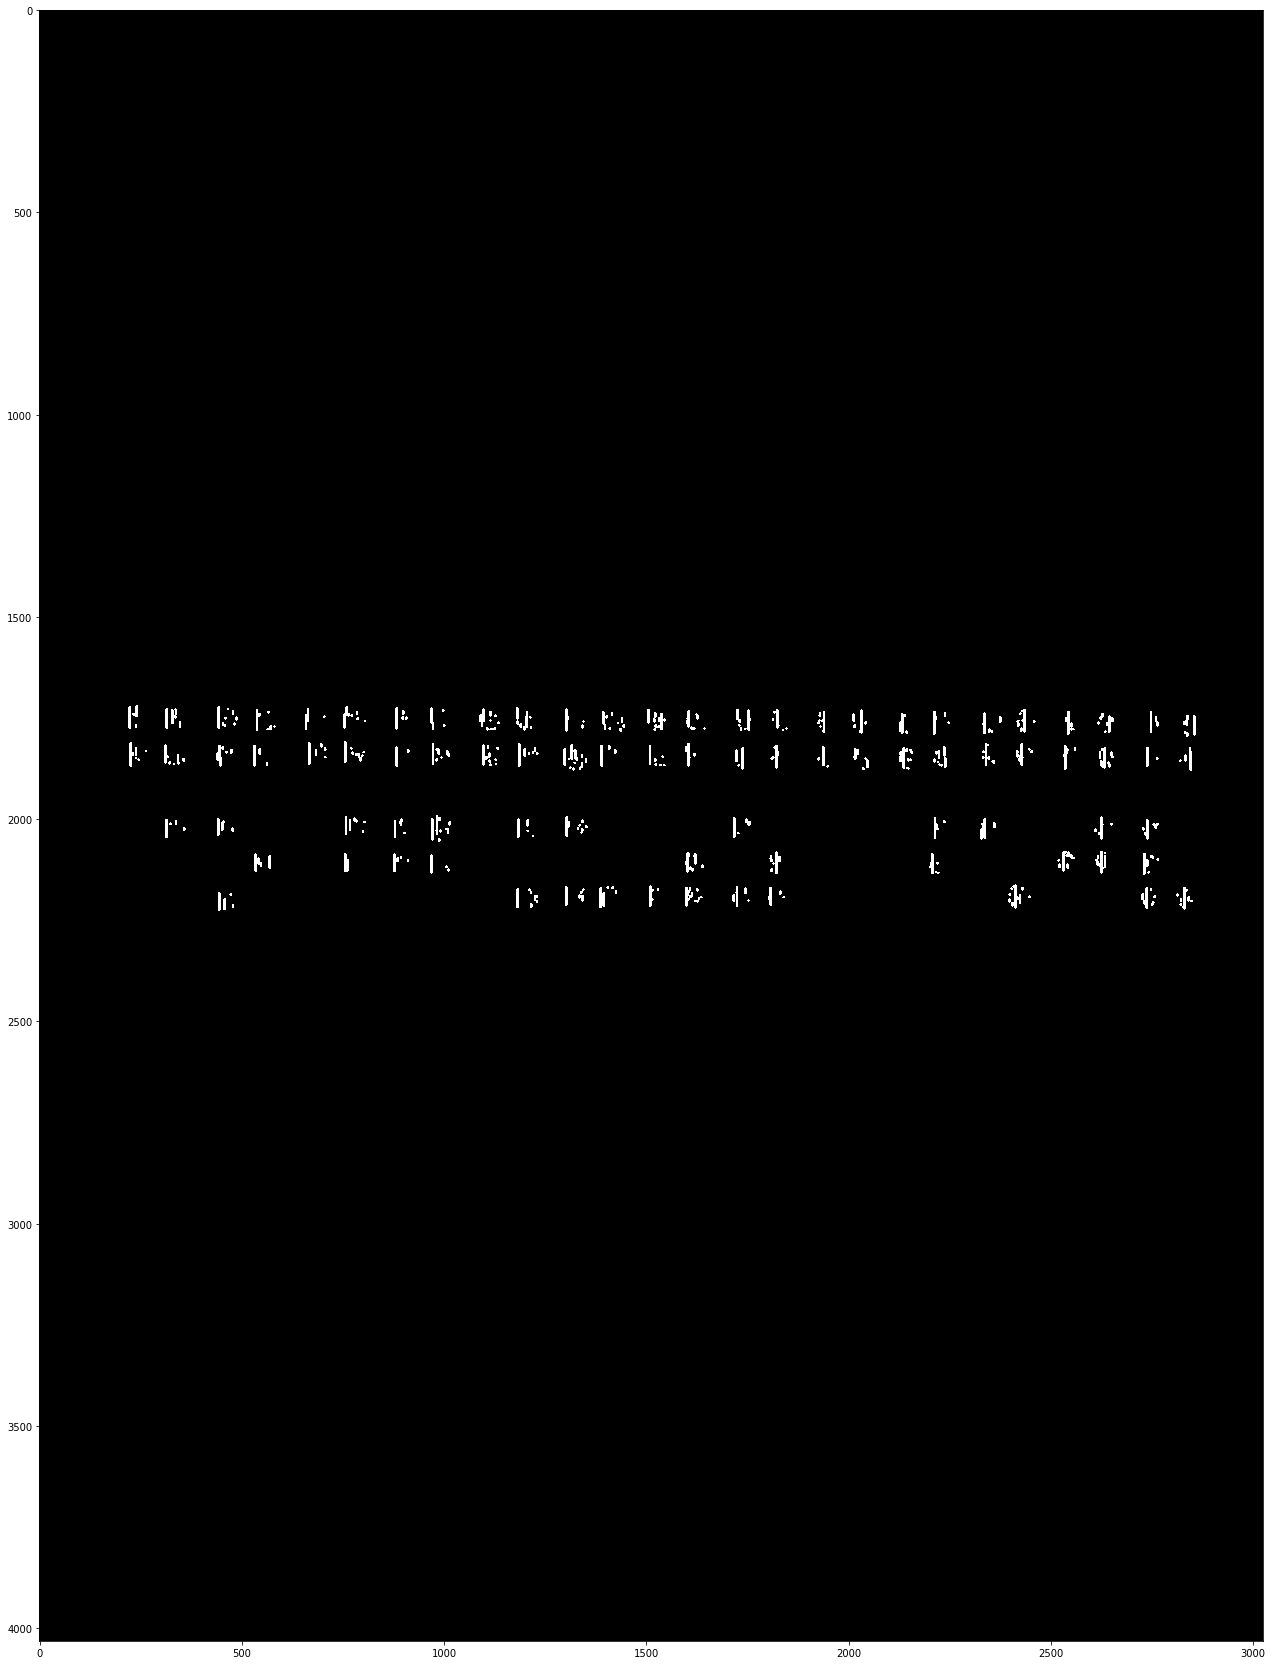

In [6]:
img1_temp_result = np.zeros((height,width,channel), dtype = np.uint8)

img1_contours_dict = []

for contour in img1_contours:
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(img1_temp_result, pt1=(x,y), pt2 = (x+2, y+h), color = (255,255,255), thickness=4)
    
    img1_contours_dict.append({
        'contour':contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x+(w/2),
        'cy':y+(h/2)     
    })

plt.figure(figsize=(30,30))
plt.imshow(img1_temp_result,cmap='gray')

#### 점자가 아닌 부분의 contour제거 & 시각적으로 점자를 표시하기 위한 사각형 만들기

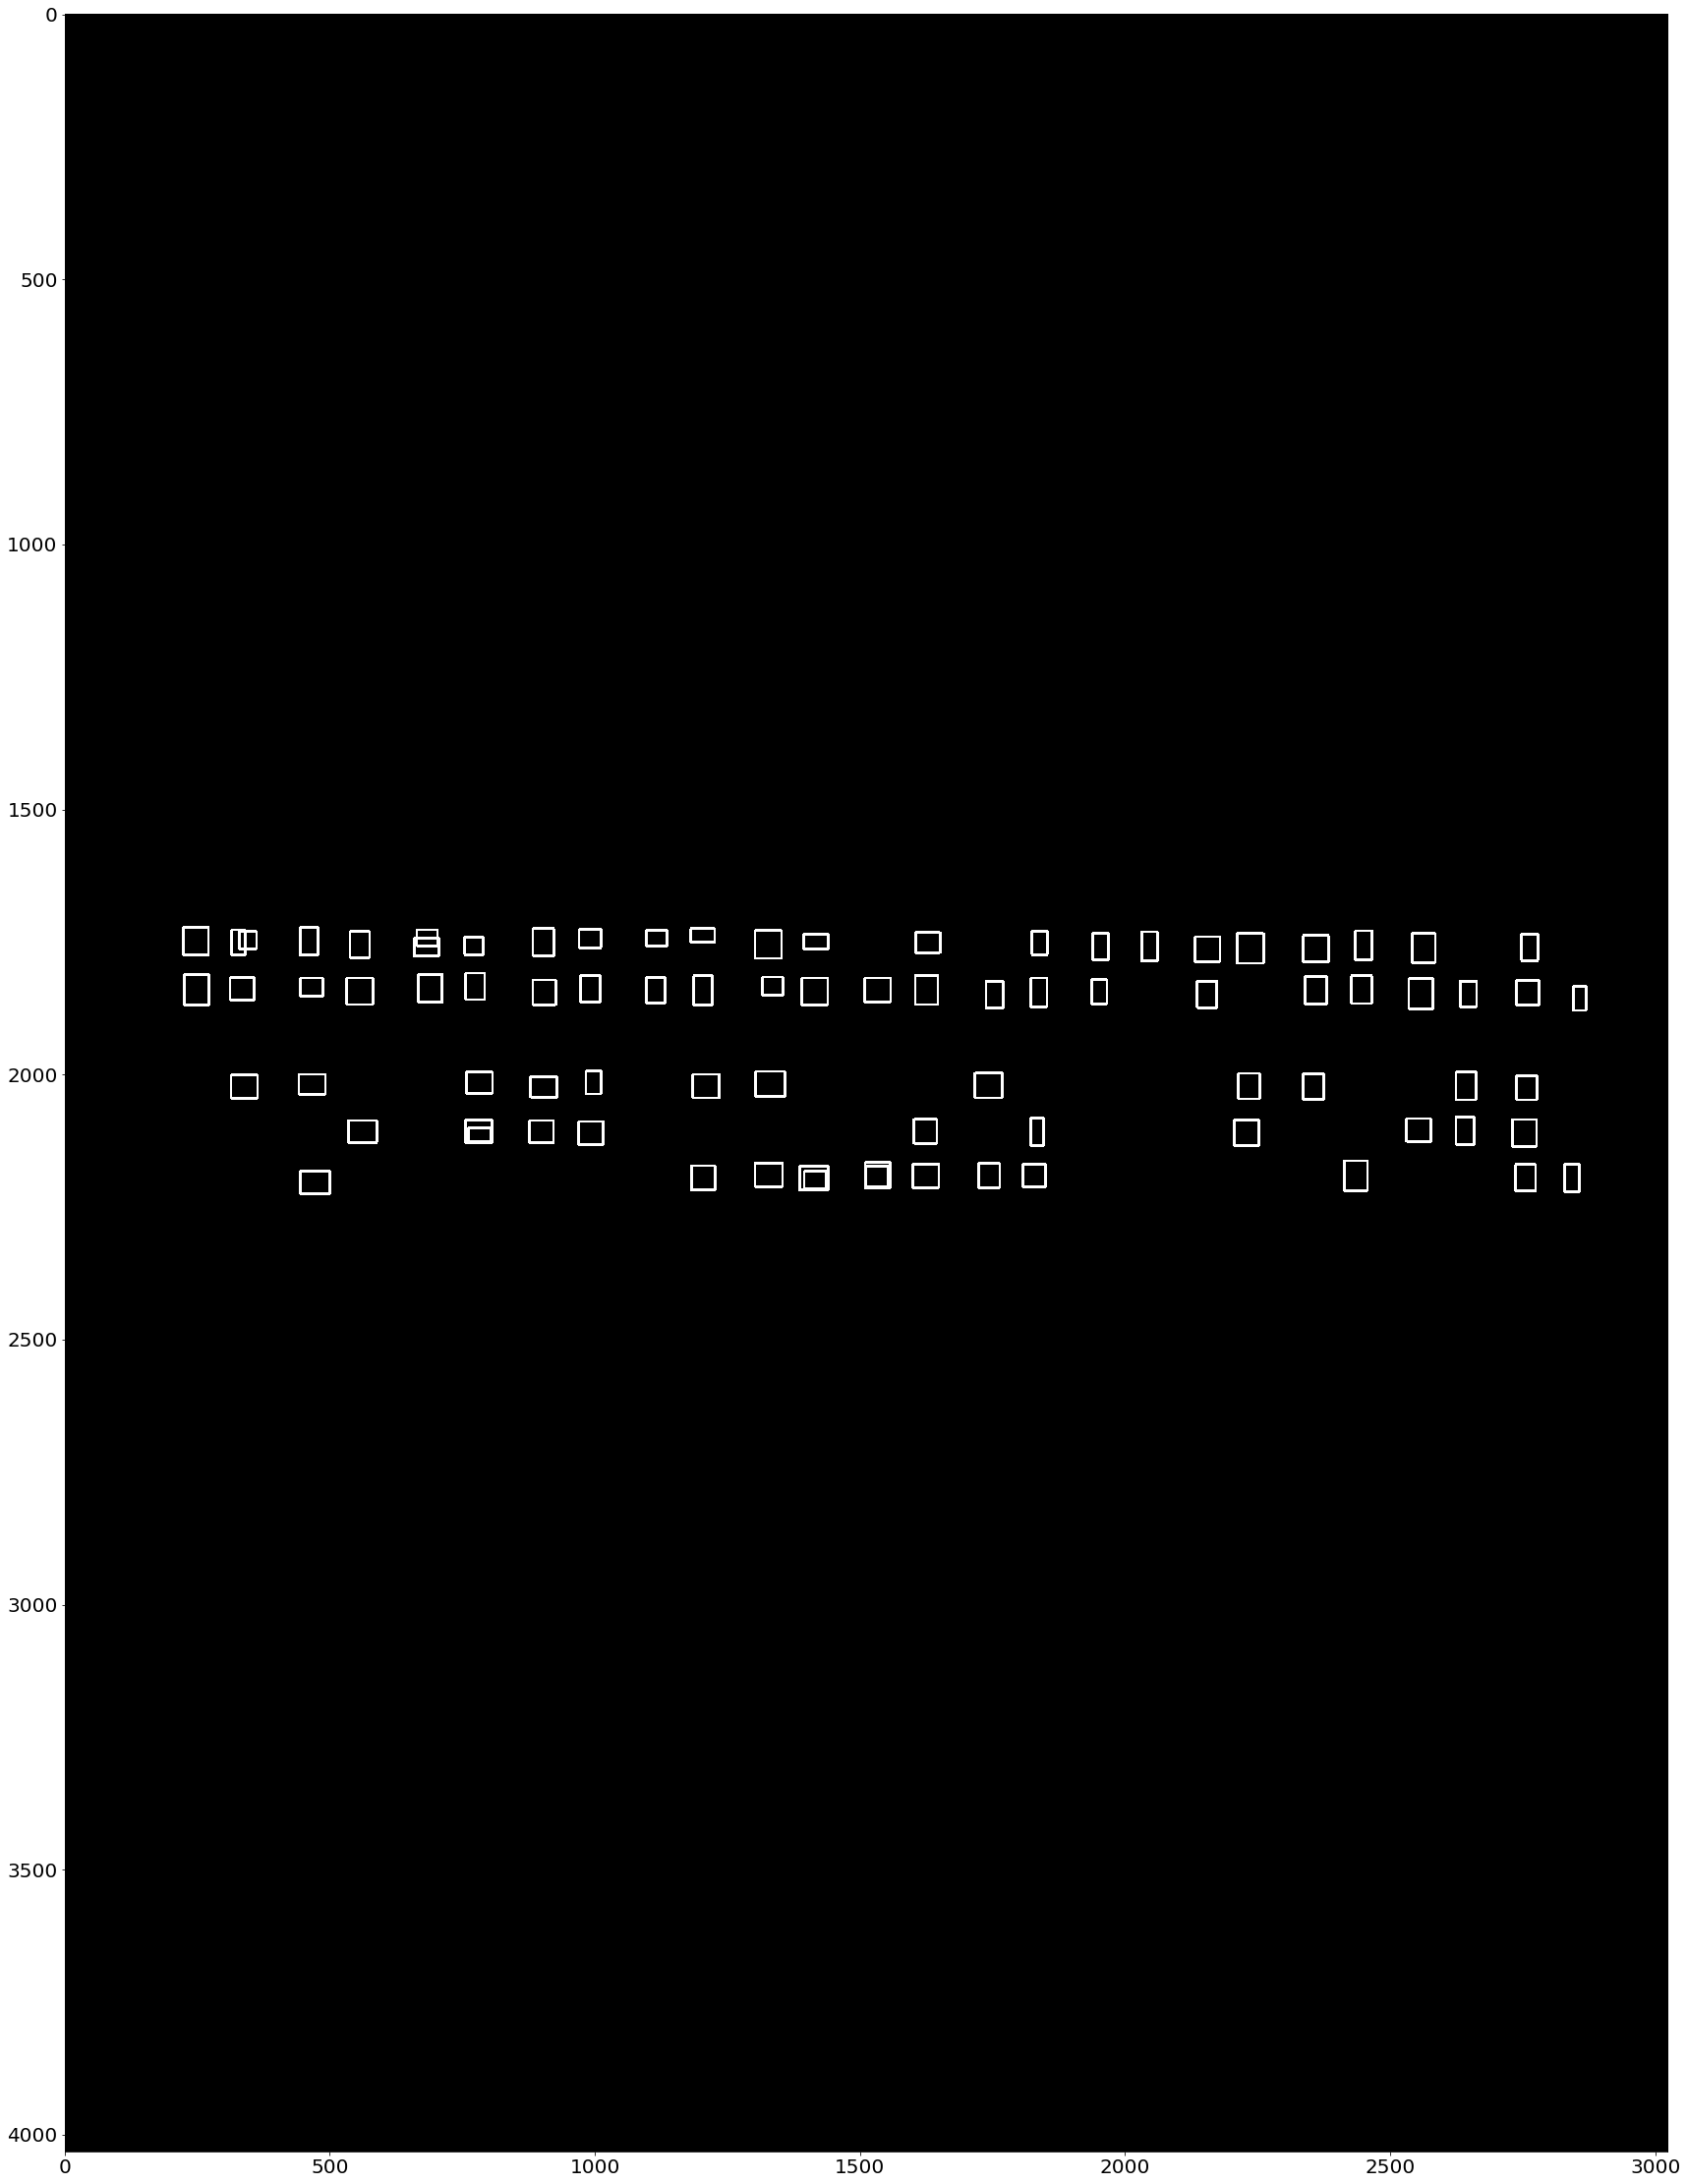

In [7]:
MIN_HEIGHT = 1
MIN_WIDTH = 1
MAX_HEIGHT = 80
MAX_WIDTH = 80
MIN_AREA = 1000
img1_possible_contours = []

cnt=0
for d in img1_contours_dict:
    area = d['w']*d['h']
    
    if MIN_HEIGHT< d['h'] < MAX_HEIGHT \
    and MIN_WIDTH< d['w'] < MAX_WIDTH \
    and MIN_AREA<area:
        d['idx'] = cnt
        cnt += 1
        img1_possible_contours.append(d)
        
img1_temp_result = np.zeros((height, width, channel),dtype = np.uint8)

for d in img1_possible_contours:
    cv2.rectangle(img1_temp_result, pt1=(d['x'],d['y']),pt2 = (d['x']+d['w'], d['y']+d['h']), color = (255,255,255), thickness=4)
    
plt.figure(figsize=(48,40))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.imshow(img1_temp_result, cmap='gray')

#### contour 오류로 인한 겹치는 사각형 제거

In [8]:
unmatched1_result_idx = []
for d1 in img1_possible_contours:     
    if d1['idx'] in unmatched1_result_idx:
        continue
    for d2 in img1_possible_contours:
        if d1['idx'] == d2['idx']:
            continue
                
        dx = abs(d1['cx'] - d2['cx'])
        dy = abs(d1['cy'] - d2['cy'])
            
        distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
        if distance<20:
                unmatched1_result_idx.append(d2['idx'])
        else:
            continue
    
matched1_result_idx=[]
for d4 in img1_possible_contours:
    if d4['idx'] not in unmatched1_result_idx:
        matched1_result_idx.append(d4['idx'])
print(matched1_result_idx)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83]


In [9]:
matched1_result = []
for idx_list in matched1_result_idx:
    matched1_result.append(np.take(img1_possible_contours, idx_list))

True

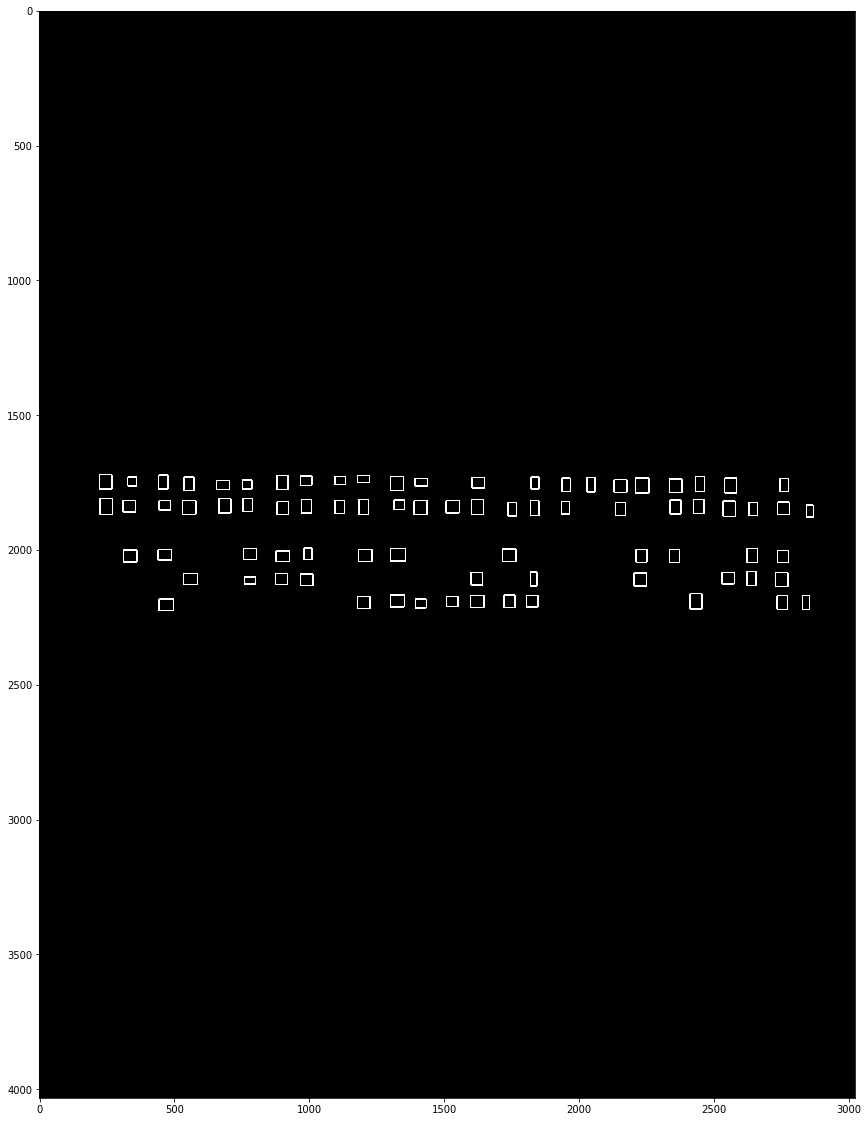

In [10]:
temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in matched1_result:
    cv2.rectangle(temp_result, pt1=(d['x'],d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=4)
        
plt.figure(figsize=(24,20))
plt.imshow(temp_result, cmap='gray')
cv2.imwrite('jeomja1_processing.jpg',temp_result)

#### 이미지의 불필요한 부분 자르기

True

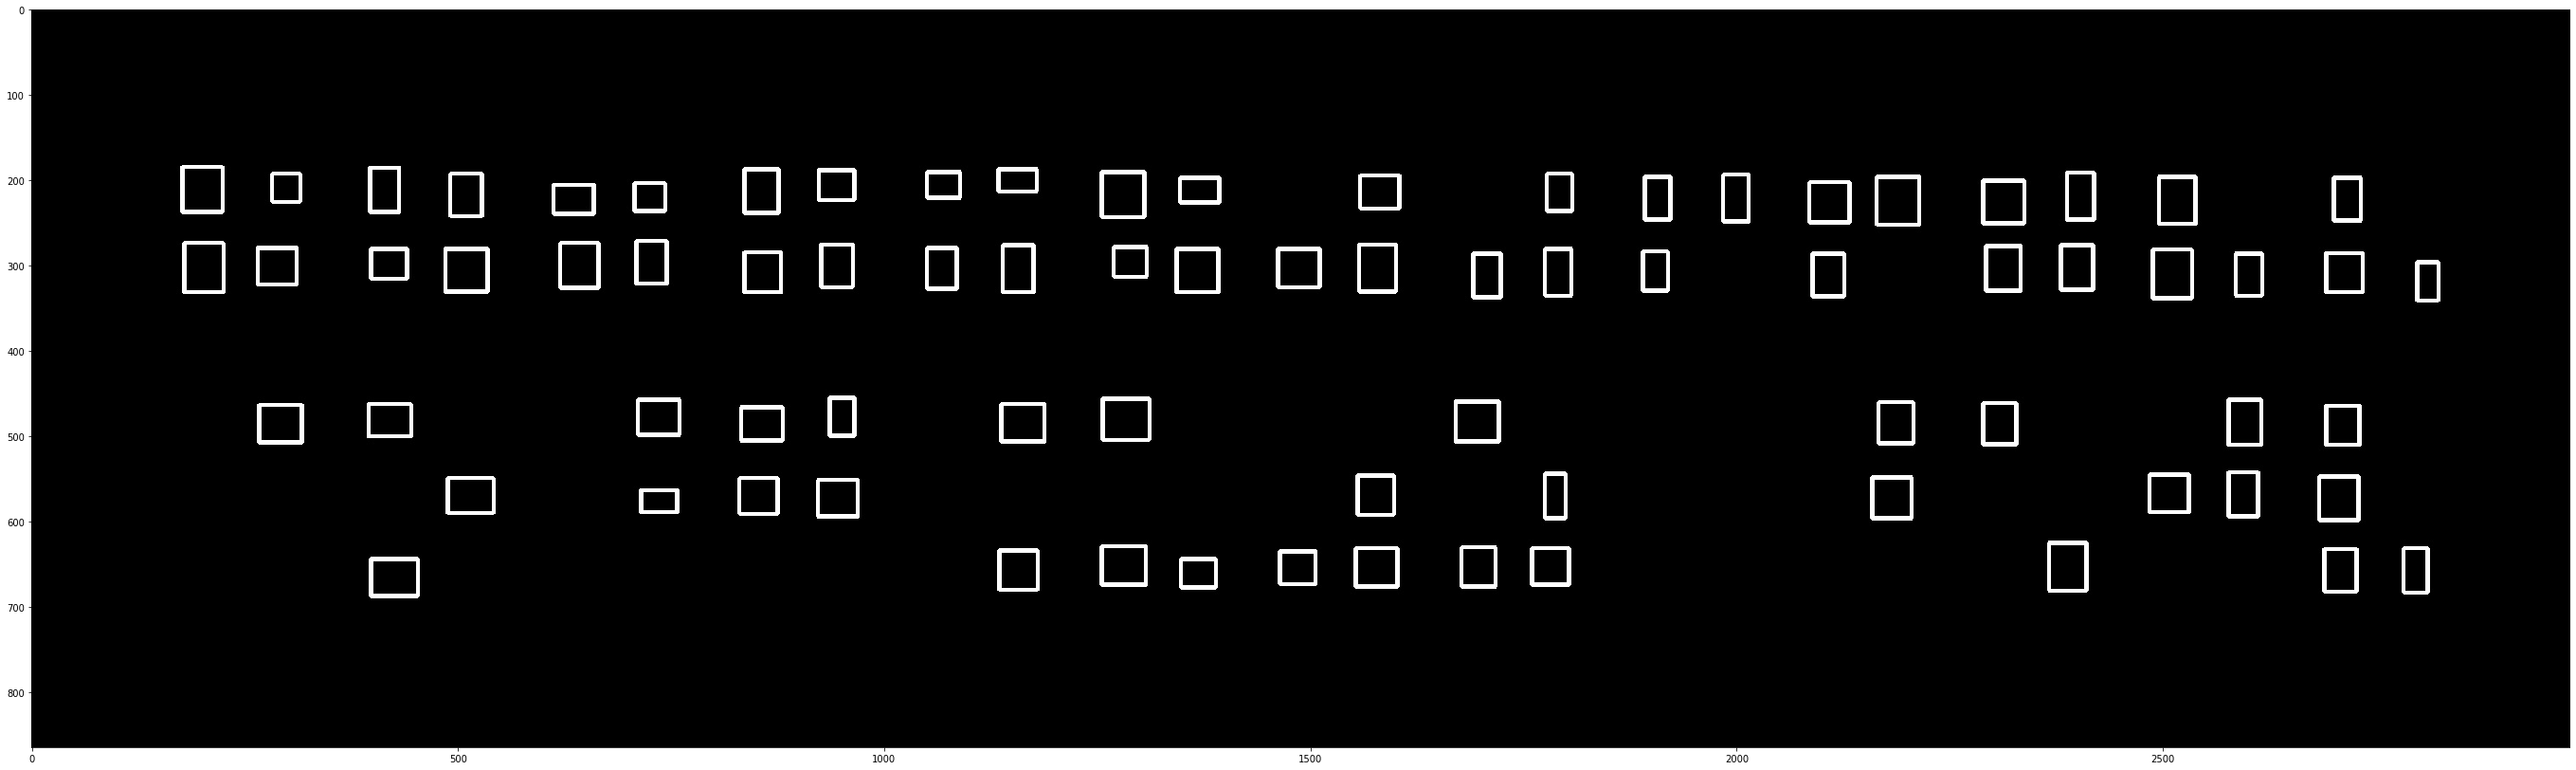

In [11]:
im = cv2.imread('jeomja1_processing.jpg')
cx_list = []
cy_list = []
w_list = []
for i in img1_possible_contours:
    cx =i['cx']
    cy =i['cy']
    w = i['w']
    cx_list.append(cx)
    cy_list.append(cy)
    w_list.append(w)
avg = sum(w_list,0.0)/len(w_list)
avg = int(avg)
cx_set= set(cx_list)
cy_set= set(cy_list)
maxx = int(max(cx_list))
minx = int(min(cx_list))
maxy = int(max(cy_list))
miny = int(min(cy_list))

pict = im[miny-200 : maxy+200,
          minx-200 : maxx+200]
plt.figure(figsize=(48,40))
plt.imshow(pict)
cv2.imwrite('jeomja1_complete.jpg', pict)

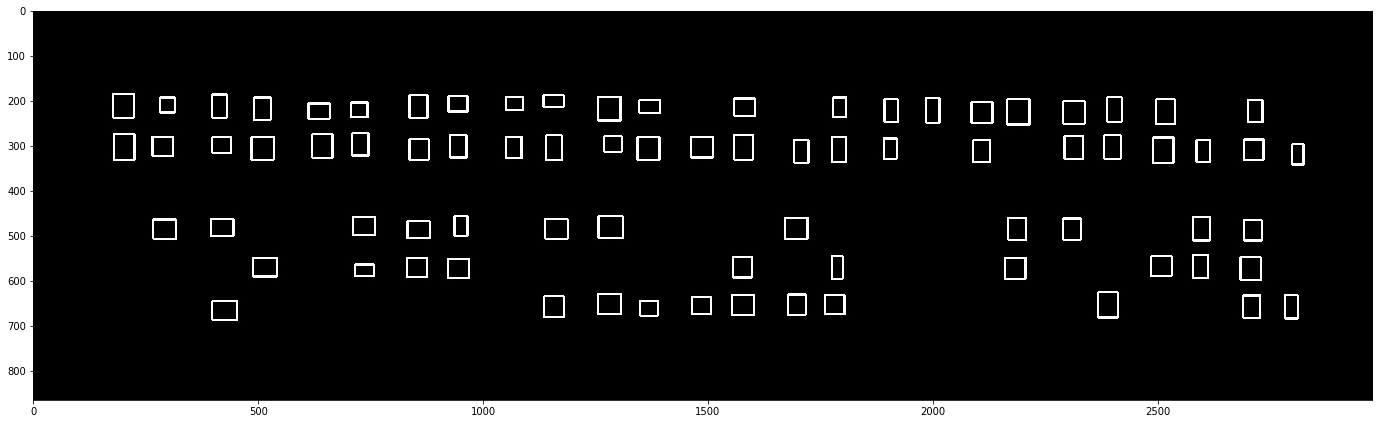

In [12]:
img='jeomja1_complete.jpg'
im = cv2.imread(img)
height, width, channel = im.shape
plt.figure(figsize = (24,20))
plt.imshow(im)

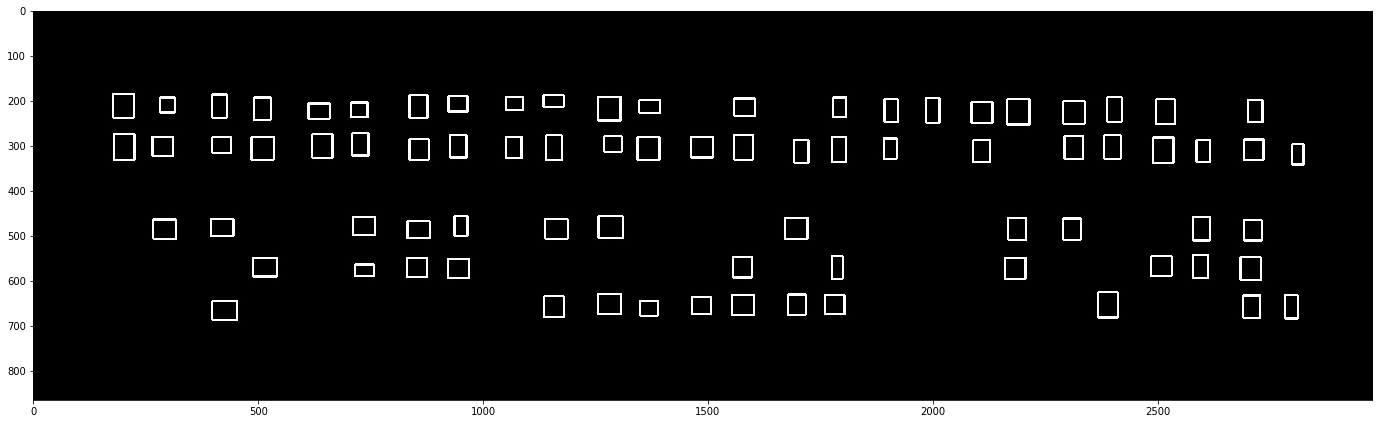

In [13]:
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(24,20))
plt.imshow(im_gray,cmap='gray')

#### 자른 이미지에 다시 contour 붙이기 & 위의 과정 반복

In [14]:
img1_contours_cut1, _ = cv2.findContours(
    im_gray,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_NONE
)

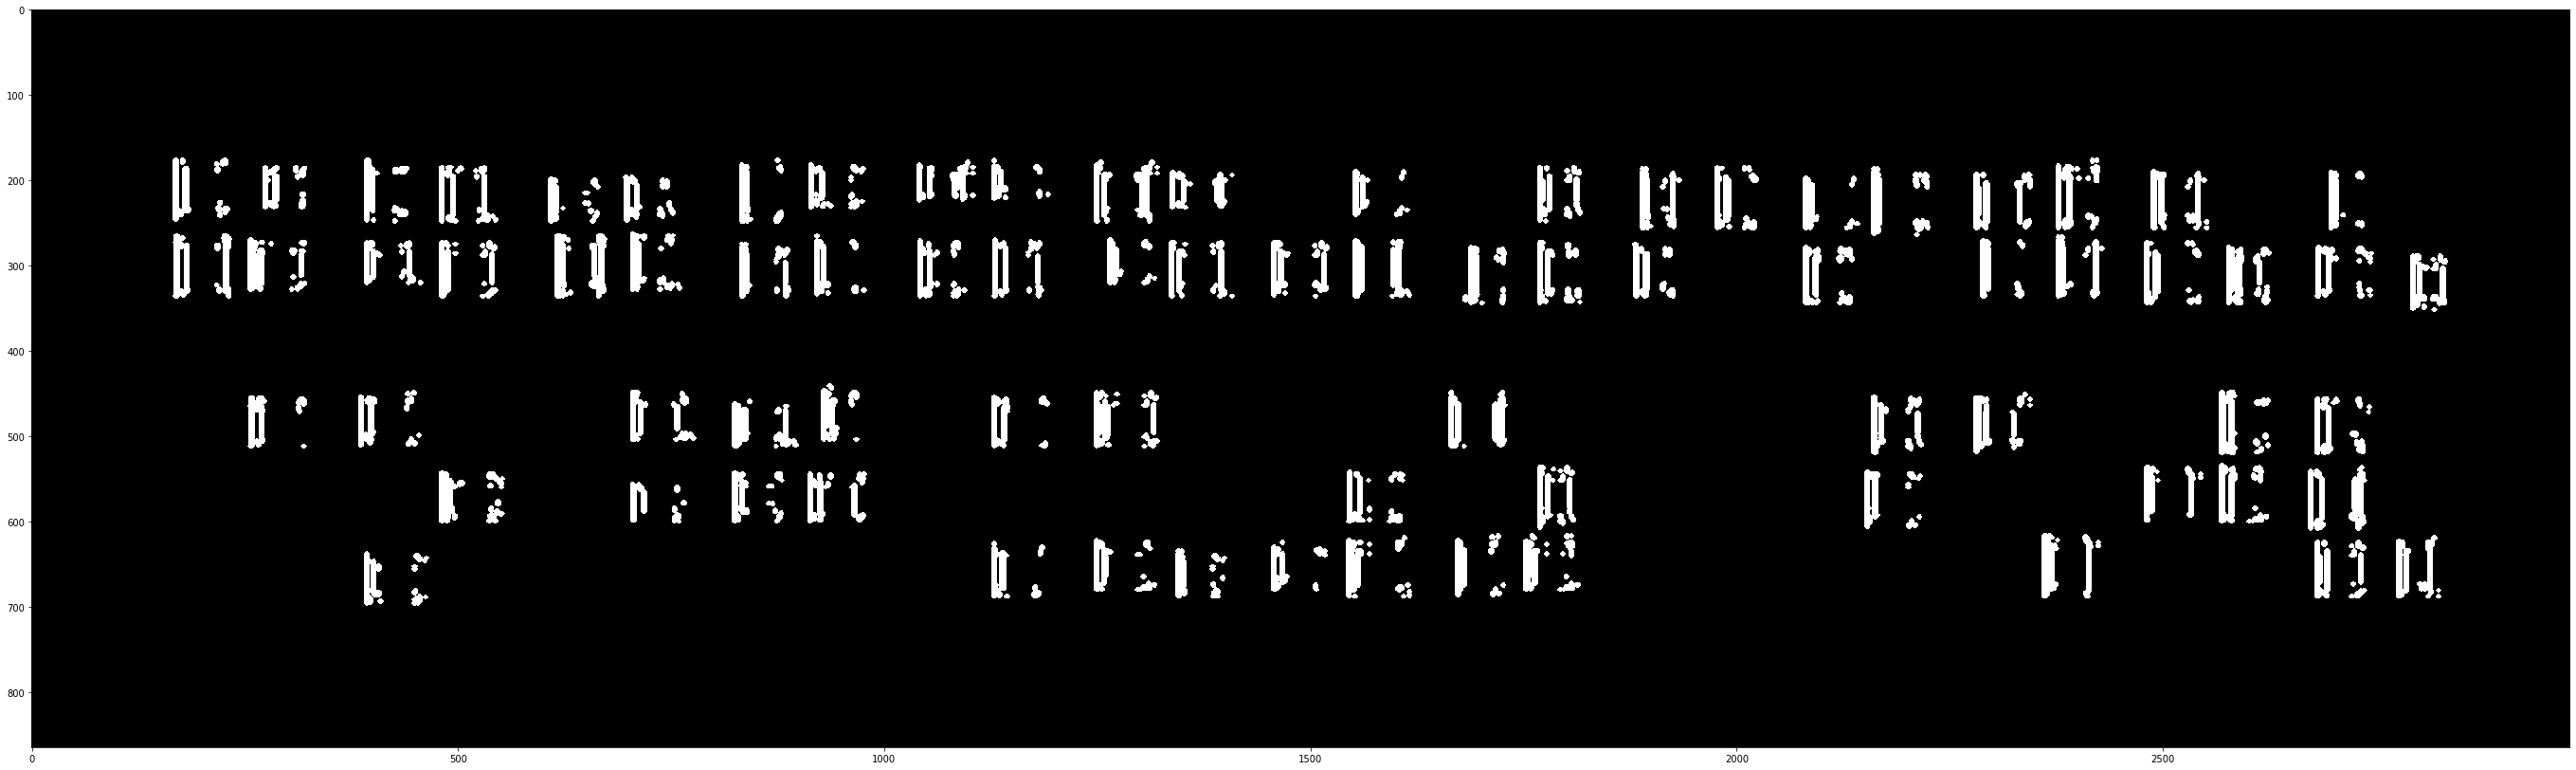

In [15]:
img1_temp_result = np.zeros((height,width,channel), dtype = np.uint8)


img1_contours_cut1_dict = []

for contour in img1_contours_cut1:
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(img1_temp_result, pt1=(x,y), pt2 = (x+2, y+h), color = (255,255,255), thickness=4)
    
    img1_contours_cut1_dict.append({
        'contour':contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x+(w/2),
        'cy':y+(h/2)     
    })
    
plt.figure(figsize=(48,40))
plt.imshow(img1_temp_result)

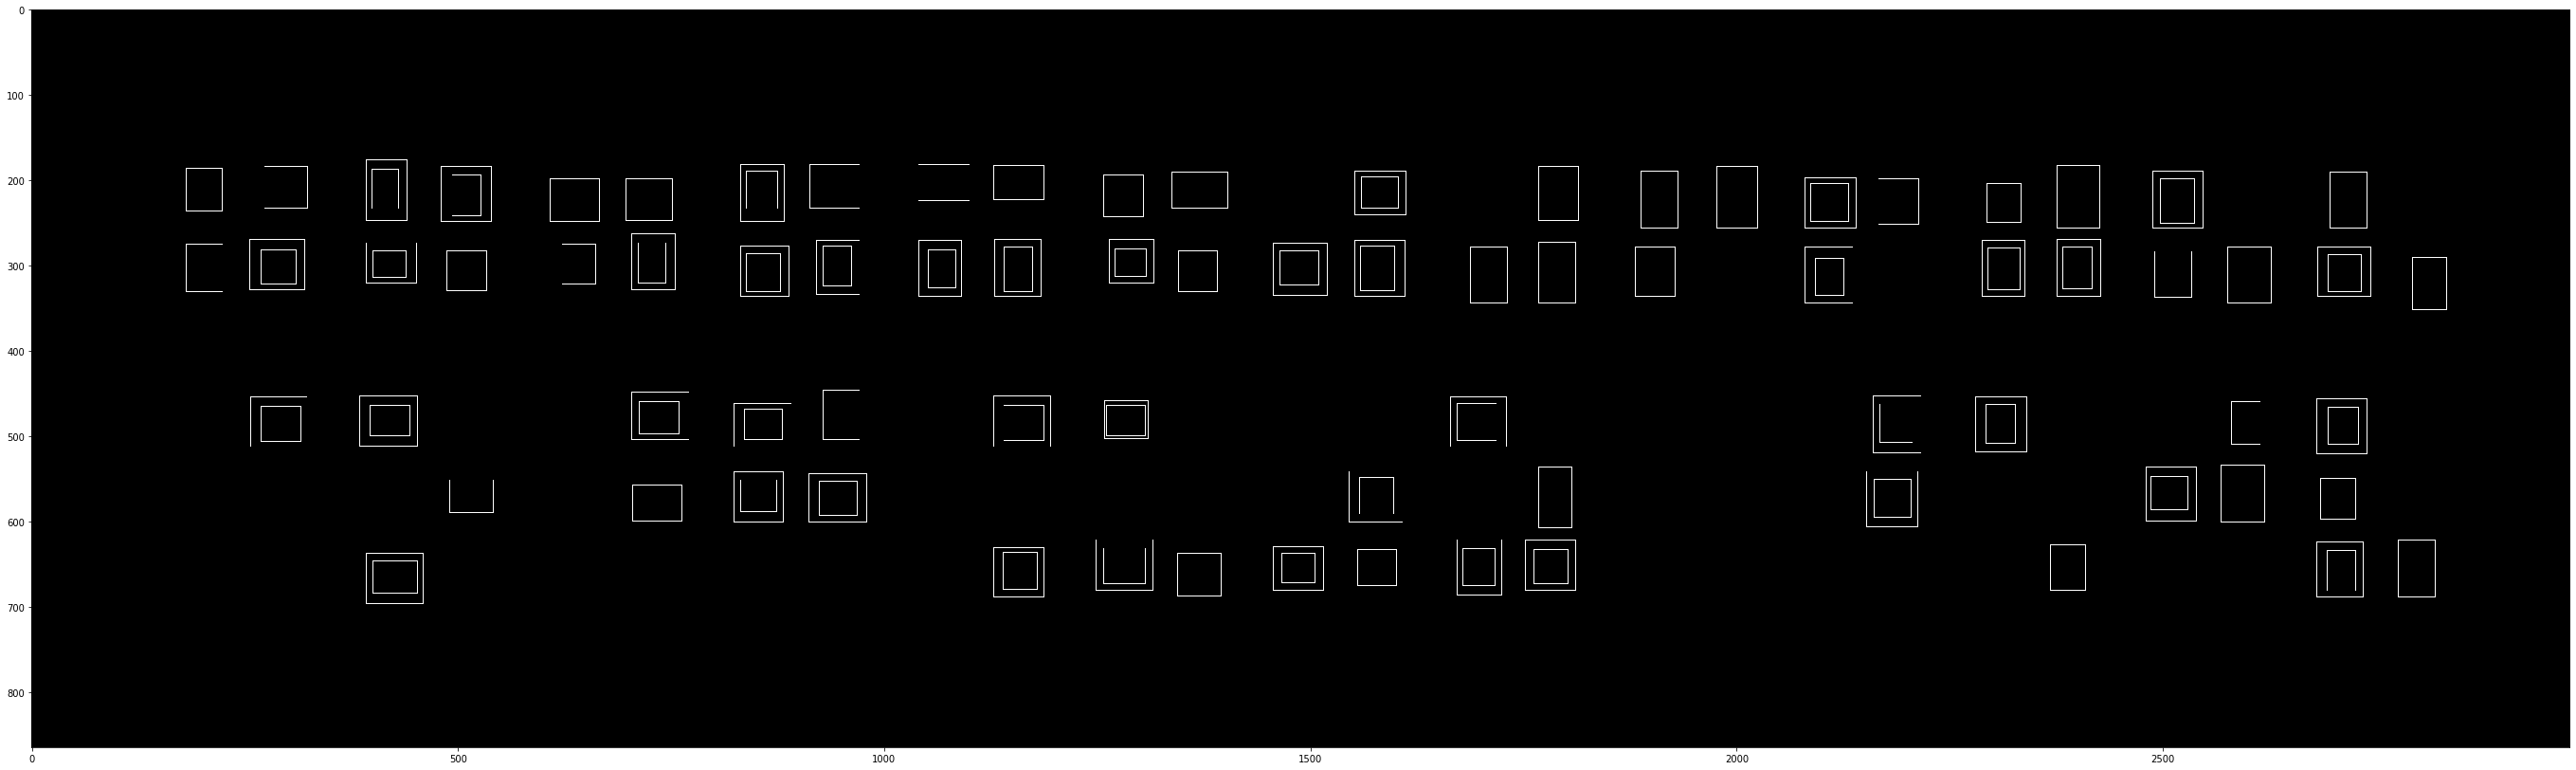

In [16]:
MIN_HEIGHT = 30

MIN_WIDTH = 30
MAX_HEIGHT = 80
MAX_WIDTH = 80
MAX_AREA = 4000
img1_possible_contours_cut1 = []

cnt=0
for d in img1_contours_cut1_dict:
    area = d['w']*d['h']
    
    if MIN_HEIGHT< d['h'] < MAX_HEIGHT \
    and MIN_WIDTH< d['w'] < MAX_WIDTH \
    and area < MAX_AREA:
        d['idx'] = cnt
        cnt += 1
        img1_possible_contours_cut1.append(d)
        
img1_temp_result = np.zeros((height, width, channel),dtype = np.uint8)


for d in img1_possible_contours_cut1:
    cv2.rectangle(img1_temp_result, pt1=(d['x'],d['y']),pt2 = (d['x']+d['w'], d['y']+d['h']), color = (255,255,255), thickness=1)
    
plt.figure(figsize=(48,40))
plt.imshow(img1_temp_result, cmap='gray')

#### 겹치는 사각형 제거

In [17]:
unmatched2_result_idx = []
for d1 in img1_possible_contours_cut1:     
    if d1['idx'] in unmatched2_result_idx:
        continue
    for d2 in img1_possible_contours_cut1:
        if d1['idx'] == d2['idx']:
            continue
                
        dx = abs(d1['cx'] - d2['cx'])
        dy = abs(d1['cy'] - d2['cy'])
            
        distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
        if distance<20:
                unmatched2_result_idx.append(d2['idx'])
        else:
            continue
    
matched2_result_idx=[]
for d4 in img1_possible_contours_cut1:
    if d4['idx'] not in unmatched2_result_idx:
        matched2_result_idx.append(d4['idx'])
print(matched2_result_idx)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 74, 75, 76, 78, 79, 81, 83, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118]


In [18]:
matched2_result = []
for idx_list in matched2_result_idx:
    matched2_result.append(np.take(img1_possible_contours_cut1, idx_list))

In [19]:
cx_cy_list=[]
for d in img1_possible_contours_cut1:
    if d['cy']>400:
        cx_cy_list.append([d['cx'],d['cy']])
cx_cy_list_sort = cx_cy_list[:]
cx_cy_list_sort = sorted(cx_cy_list_sort)

True

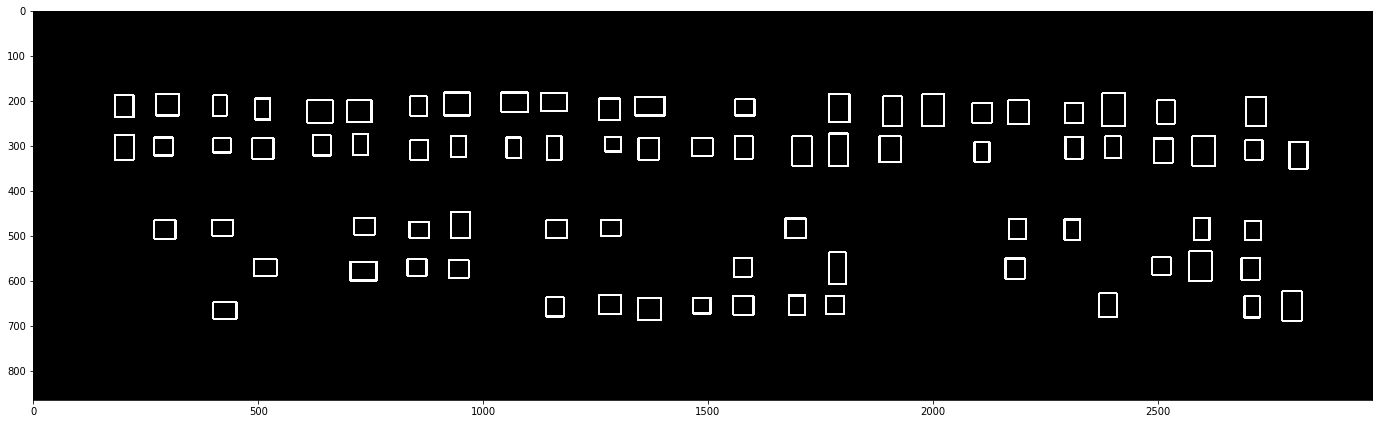

In [20]:
temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in matched2_result:
    cv2.rectangle(temp_result, pt1=(d['x'],d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=4)
        
plt.figure(figsize=(24,20))
plt.imshow(temp_result, cmap='gray')
cv2.imwrite('jeomja1_processed.jpg',temp_result)

#### 점자 번역함수 제작
초성, 중성, 종성, 띄어쓰기, 약어 구분하여 숫자 매기기

In [21]:
def Zeomza2Hangul(dictionary, y_list, Hangul='Hangul.txt'):
    f = open(Hangul,'a+')
    Zeomza_list = []
    sectionX_1 = range(dictionary[0][0] ,int(0.5*(dictionary[0][0]+dictionary[0][1])))
    sectionX_2 = range(int(0.5*(dictionary[0][0]+dictionary[0][1])), dictionary[0][1])
    sectionY_1 = range(y_list[0], y_list[1])
    sectionY_2 = range(y_list[1],y_list[2])
    sectionY_3 = range(y_list[2],y_list[3])
    for d in dictionary[1]:
        cx = int(d[0])
        cy = int(d[1])
        if cx in sectionX_1:
            if cy in sectionY_1:
                Zeomza_list.append(1)
            elif cy in sectionY_2:
                Zeomza_list.append(3)
            elif cy in sectionY_3:
                Zeomza_list.append(5)
            else:
                print("error1! Please try again")
        elif cx in sectionX_2:
            if cy in sectionY_1:
                Zeomza_list.append(2)
            elif cy in sectionY_2:
                Zeomza_list.append(4)
            elif cy in sectionY_3:
                Zeomza_list.append(6)
            else:
                print("error2! Please try again")
        else:
            print("error3! Please try again")
    Zeomza_list = set(Zeomza_list)
    if len(Zeomza_list) == 0:
        f.write(' 0')
    elif len(Zeomza_list) == 1:
        if 1 in Zeomza_list:
            f.write('ㄱ3')
        elif 2 in Zeomza_list:
            f.write('ㄱ1')
        elif 3 in Zeomza_list:
            f.write('ㄹ3')
        elif 4 in Zeomza_list:
            f.write('ㄹ1')
        elif 5 in Zeomza_list:
            f.write('ㅅ3')
        elif 6 in Zeomza_list:
            f.write('ㅅ1')
    elif len(Zeomza_list) == 2:
        if (1 in Zeomza_list and 2 in Zeomza_list):
            f.write('ㄴ1')
        elif (3 in Zeomza_list and 4 in Zeomza_list):
            f.write('ㄴ3')
        elif (1 in Zeomza_list and 3 in Zeomza_list):
            f.write('ㅂ3')
        elif (2 in Zeomza_list and 4 in Zeomza_list):
            f.write('ㅂ1')
        elif (1 in Zeomza_list and 4 in Zeomza_list):
            f.write('ㅁ1')
        elif (3 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅁ3')
        elif (1 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅈ3')
        elif (2 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅈ1')
        elif (1 in Zeomza_list and 6 in Zeomza_list):
            f.write('연4')
        elif (2 in Zeomza_list and 3 in Zeomza_list):
            f.write('ㄷ1')
        elif (4 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㄷ3')
        elif (3 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅊ3')
        elif (4 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅊ1')
    elif len(Zeomza_list) == 3:
        if (1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list):
            f.write('ㅋ1')
        elif (3 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅋ3')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 4 in Zeomza_list):
            f.write('ㅍ1')
        elif (3 in Zeomza_list and 4 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅍ3')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅜ2')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅠ2')
        elif (1 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list):
            f.write('ㅌ1')
        elif (3 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅌ3')
        elif (1 in Zeomza_list and 3 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅏ2')
        elif (1 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅣ2')
        elif (1 in Zeomza_list and 4 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅕ2')
        elif (1 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅗ2')
        elif (2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list):
            f.write('ㅎ1')
        elif (4 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅎ3')
        elif (2 in Zeomza_list and 3 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅓ2')
        elif (2 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅑ2')
        elif (2 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅛ2')
    elif len(Zeomza_list) == 4:
        if (1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list):
            f.write('(ㅇ1운4)')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅞ')
        elif (3 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅇ3')
        elif (1 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅐ2')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅔ2')
        elif (1 in Zeomza_list and 3 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅘ2')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list and 5 in Zeomza_list):
            f.write('ㅝ2')
        elif (2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 6 in Zeomza_list):
            f.write('ㅢ2')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 4 in Zeomza_list and 6 in Zeomza_list):
            f.write('억4')
        elif (2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list):
            f.write('얼4')    
        elif (1 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 6 in Zeomza_list):
            f.write('열4')
        elif (1 in Zeomza_list and 2 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('옥4')
        elif (1 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('은4')
        elif (2 in Zeomza_list and 3 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list):
            f.write('을4')
    elif len(Zeomza_list) == 5:
        if 1 in Zeomza_list and 2 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list:
            f.write('ㅚ2')
        elif 2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list:
            f.write('언4')
        elif 1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 6 in Zeomza_list:
            f.write('영4')
        elif 1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list and 5 in Zeomza_list and 6 in Zeomza_list:
            f.write('울4')
        elif 1 in Zeomza_list and 2 in Zeomza_list and 3 in Zeomza_list and 4 in Zeomza_list and 5 in Zeomza_list:
            f.write('인4')
    elif len(Zeomza_list) == 6:
        f.write('옹4')
    f.close()
    f = open(Hangul,'r')
    text = f.read()
    f.close()
    return text

#### 음소 별로 dictionary에 저장
점자간의 간격을 구하여 틀을 만든 다음, 틀 별로 안에 있는 점자를 함께 dictionary에 저장

In [22]:
cx_list2 = []
cy_list2 = []
w_list2 = []
for i in img1_possible_contours_cut1:
    cx = i['cx']
    cy = i['cy']
    w = i['w']
    cx_list2.append(cx)
    cy_list2.append(cy)
    w_list2.append(w)
avg = sum(w_list2,0.0)/len(w_list2)
avg =int(avg)

Large_cy_list2 = []
Small_cy_list2 = []
for j in cy_list2:
    if j<400:
        Small_cy_list2.append(j)
    elif 400<= j:
        Large_cy_list2.append(j) 

cx_list2 = sorted(cx_list2)
a= cx_list2[0]
count_num = 0  #cx와 cx사이의 거리
while a <= cx_list2[3]:
    a = a +1
    count_num = count_num + 1
#x좌표 잘리는 거리    
x_distance= int(count_num + avg + 51)  
first_x_coordinate= cx_list2[0] - avg/2  - 25
first_x_coordinate= int(first_x_coordinate)
Large_cy_list2 = sorted(Large_cy_list2)
minimum_cy_list2 = min(Large_cy_list2)
maximum_cy_list2 = max(Large_cy_list2)
differ = maximum_cy_list2 - minimum_cy_list2
y_distance = int(differ*1.5)
first_y_coordinate = int(Large_cy_list2[0] - avg/2 - 25)
im = cv2.imread('jeomja1_processed.jpg')
x1_x2_list =[]
for i in range(1,13):
    x1 = first_x_coordinate
    x2 = first_x_coordinate + x_distance
    list_in_list = [x1,x2]
    x1_x2_list.append(list_in_list)
    cx_list_new = []
    for j in cx_list2:
        if j > first_x_coordinate+ x_distance:
            cx_list_new.append(j)
    first_x_coordinate = int(cx_list_new[0] - avg/2 - 25)
x1 = first_x_coordinate
x2 = first_x_coordinate + x_distance
list_in_list = [x1,x2]
x1_x2_list.append(list_in_list)

coordinate_dict = {}
idx = 0
plus_list = []
for d in x1_x2_list:
    for i in cx_cy_list_sort:
        if d[0] < i[0] < d[1]:
            plus_list.append(i)
    coordinate_dict[idx] = [d,plus_list]
    plus_list = []
    idx += 1

In [23]:
y0 = int(first_y_coordinate)
y1 = int(first_y_coordinate + 1/3*y_distance)
y2 = int(first_y_coordinate + 2/3*y_distance)
y3 = int(first_y_coordinate + y_distance)
y1_y2_list = [y0,y1,y2,y3]


#### 함수를 이용해 각각의 음소를 한글로 변환
Hangul.txt에 저장

In [24]:
for i in range(len(coordinate_dict)):
    Zeomza2Hangul(coordinate_dict[i],y1_y2_list)